In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings

warnings.filterwarnings("ignore")

plt.rcParams["axes.spines.top"] = False  
plt.rcParams["axes.spines.right"] = False

lm = LinearRegression()
sc = MinMaxScaler()

In [3]:
google = pd.read_csv("dataGOOGLday2024.csv")
ms = pd.read_csv("dataMSFTday2024.csv")

companylist = [google,ms]
companyname = ["Google","Microsoft"]

In [4]:
google['Date'] = pd.to_datetime(google['Date'])
ms['Date'] = pd.to_datetime(ms['Date'])

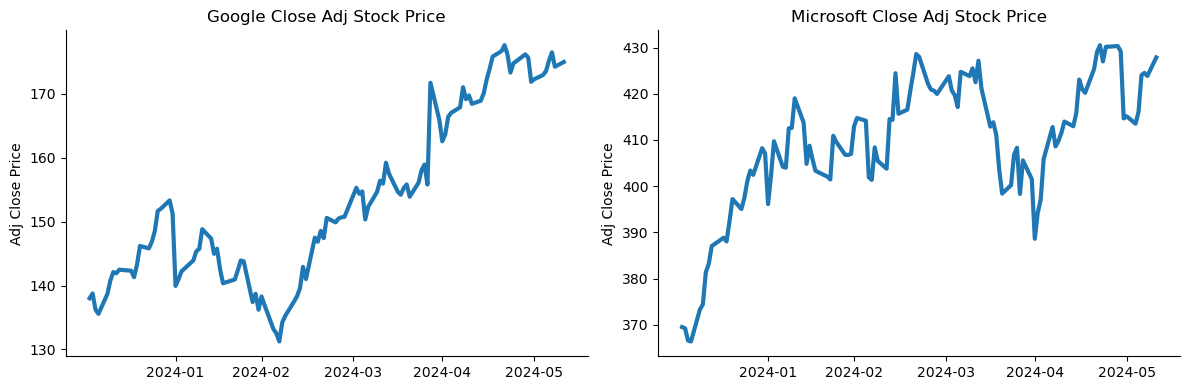

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

for i, (com, name) in enumerate(zip(companylist, companyname)):
    ax[i].plot(com["Date"],com["Adj Close"],linewidth=3)
    ax[i].set_ylabel("Adj Close Price") 
    ax[i].set_title(f"{name} Close Adj Stock Price")
    ax[i].set_xticks(pd.date_range(start=com["Date"].min(), end=com["Date"].max(), freq='1ME'))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

plt.tight_layout()

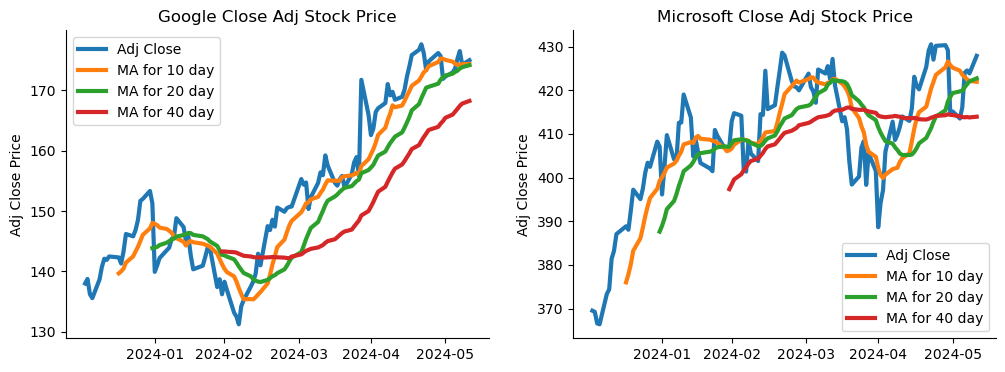

In [6]:
malist = [10,20,40]

for ma in malist:
    for com in companylist:
        com[f"MA for {ma} day"] = com["Adj Close"].rolling(window=ma).mean()

fig, ax = plt.subplots(1,2, figsize=(12,4))

for i, (com, name) in enumerate(zip(companylist, companyname)):
    ax[i].plot(com["Date"],com["Adj Close"], label="Adj Close",linewidth=3)
    ax[i].plot(com["Date"],com["MA for 10 day"], label="MA for 10 day",linewidth=3)
    ax[i].plot(com["Date"],com["MA for 20 day"], label="MA for 20 day",linewidth=3)
    ax[i].plot(com["Date"],com["MA for 40 day"], label="MA for 40 day",linewidth=3)
    ax[i].set_ylabel("Adj Close Price") 
    ax[i].set_title(f"{name} Close Adj Stock Price")
    ax[i].set_xticks(pd.date_range(start=com["Date"].min(), end=com["Date"].max(), freq='1ME'))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
    ax[i].legend()

In [7]:
for com in companylist:
    com.drop(columns=["Open","High","Low","Close","Volume"],inplace=True)
    com["last day"] = com["Adj Close"].shift(1)

0.003228309261629647 [0.22001411 0.78372955]
Google R^2: 0.9559309860522888
Google MSE: 7.6800955985828825
46.112589351000906 [0.13232769 0.75715353]
Microsoft R^2: 0.7884973972827716
Microsoft MSE: 23.434901120800443


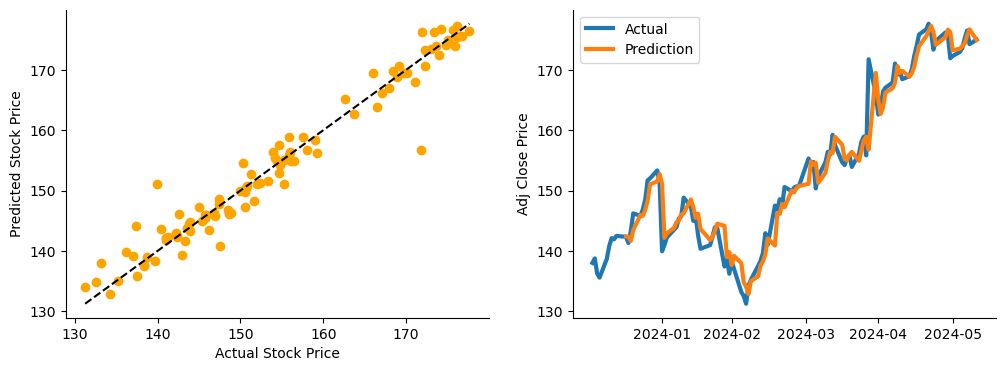

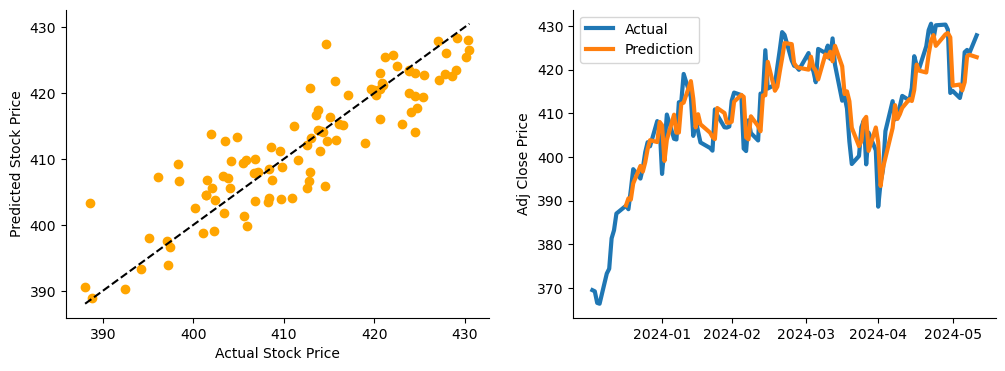

In [8]:
for i, (com, name) in enumerate(zip(companylist, companyname)):
    X = com.drop(columns=["Date","Adj Close","MA for 20 day","MA for 40 day"]).dropna()
    y = com["Adj Close"][-len(X):]

    # fitting the model
    lm.fit(X,y)
    #LR_model.append(lm)
    #LR_score.append(lm.score(X,y))
    print(lm.intercept_,lm.coef_)
    print(f"{name} R^2: {lm.score(X,y)}")

    fig, ax = plt.subplots(1,2, figsize=(12,4))

    # plotting training prediction vs observation
    ax[0].scatter(y,lm.predict(X),color="orange")
    ax[0].plot(np.linspace(min(y),max(y),100),np.linspace(min(y),max(y),100),color="black",linestyle="--")
    ax[0].set_xlabel("Actual Stock Price")
    ax[0].set_ylabel("Predicted Stock Price")

    X = X.reset_index(drop=True)
    X = pd.concat([X,pd.Series(lm.predict(X))],axis=1)
    Prediction = pd.merge(com,X,on="MA for 10 day",how="left")
    Prediction.rename(columns={0:"Prediction"},inplace=True)

    # calculating the MSE
    #LR_MSE.append(np.sum((Prediction["Prediction"]-Prediction["Adj Close"])**2)/ len(X))
    print(f"{name} MSE: {np.sum((Prediction['Prediction']-Prediction['Adj Close'])**2)/ len(X)}")

    ax[1].plot(com["Date"],com["Adj Close"],linewidth=3,label="Actual")
    ax[1].plot(Prediction["Date"],Prediction["Prediction"],linewidth=3,label="Prediction")
    ax[1].set_ylabel("Adj Close Price")
    ax[1].set_xticks(pd.date_range(start=com["Date"].min(), end=com["Date"].max(), freq='1ME'))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax[1].legend()

In [9]:
def preprocess(data,windows):
    x,y = [],[]
    for i in range(len(data)-windows):
        x.append(data[i:i+windows])
        y.append(data[i+windows])
    return TensorDataset(torch.tensor(x).float(),torch.tensor(y).float())

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)  
        self.fc2 = nn.Linear(50, 30)  
        self.fc3 = nn.Linear(30, output_size)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Google Simple NN MSE: 7.195167095764623
Microsoft Simple NN MSE: 25.498158208592464


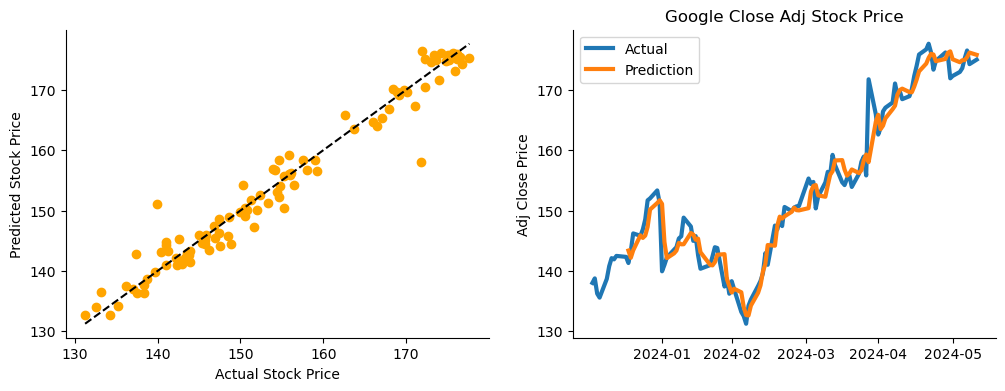

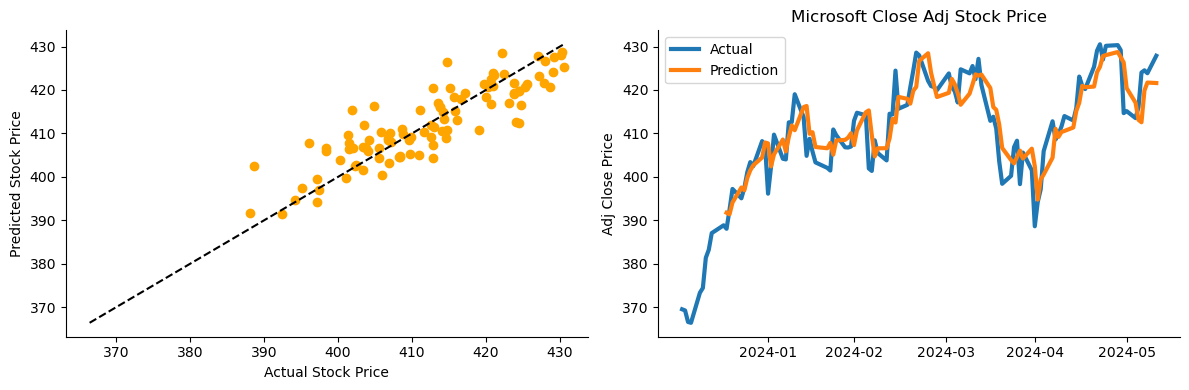

In [11]:
# Hyperparameters
windows = 10
input_size = windows  # Set input size to the number of windows
hidden_size = 50      # Size of the hidden layer
output_size = 1

for i, (com, name) in enumerate(zip(companylist, companyname)):
    data = sc.fit_transform(com["Adj Close"].values.reshape(-1, 1))

    # Data preprocessing
    dataset = preprocess(data, windows)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Simple NN model initiation
    NN = SimpleNN(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(NN.parameters(), lr=0.001)

    # Training the NN
    num_epochs = 100
    for epoch in range(num_epochs):
        for batch_data, batch_target in dataloader:
            optimizer.zero_grad()
            output = NN(batch_data.view(-1,10))  # Forward pass
            loss = criterion(output, batch_target)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

    NN.eval()

    # Prediction and record
    Prediction = pd.DataFrame(com["Adj Close"].values, columns=["Adj Close"])

    # Predicting on the entire dataset
    predicted_prices = []
    for j in range(len(data) - windows):
        last_sequence = torch.FloatTensor(data[j:j + windows].reshape(1, -1))  # Reshape for input
        with torch.no_grad():
            predicted_price = NN(last_sequence)  # Make prediction
        predicted_prices.append(sc.inverse_transform(predicted_price.numpy())[0][0])  # Store predicted price

    # Create a DataFrame for predictions
    Prediction["Prediction"] = np.nan
    Prediction["Prediction"].iloc[windows:] = predicted_prices  # Fill predictions starting from the 'windows' index

    # Calculating the MSE
    mse = np.sum((Prediction["Prediction"].dropna() - Prediction["Adj Close"].dropna()) ** 2) / len(Prediction["Prediction"].dropna())
    print(f"{name} Simple NN MSE: {mse}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Scatter plot of actual vs predicted prices
    ax[0].scatter(Prediction["Adj Close"], Prediction["Prediction"], color="orange")
    ax[0].plot(np.linspace(min(Prediction["Adj Close"]), max(Prediction["Adj Close"]), 100),
               np.linspace(min(Prediction["Adj Close"]), max(Prediction["Adj Close"]), 100),
               color="black", linestyle="--")
    ax[0].set_xlabel("Actual Stock Price")
    ax[0].set_ylabel("Predicted Stock Price")

    # Plotting the stock price with both prediction and observation
    ax[1].plot(com["Date"], com["Adj Close"], linewidth=3, label="Actual")
    ax[1].plot(com["Date"], Prediction["Prediction"], label="Prediction", linewidth=3)
    ax[1].set_ylabel("Adj Close Price")
    ax[1].set_xticks(pd.date_range(start=com["Date"].min(), end=com["Date"].max(), freq='1ME'))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax[1].legend()
    ax[1].set_title(f"{name} Close Adj Stock Price")

plt.tight_layout()
plt.show()

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers=3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (h_n,c_n) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])  
        return out

Google LSTM MSE: 11.538435890318567
Microsoft LSTM MSE: 32.64573076567471


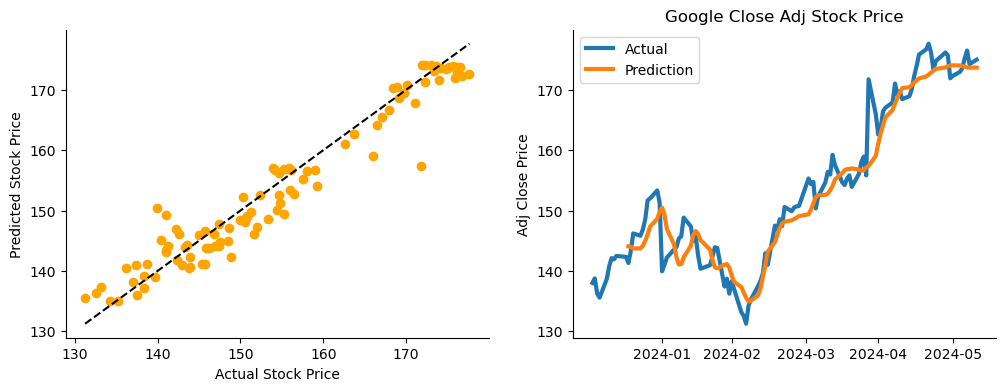

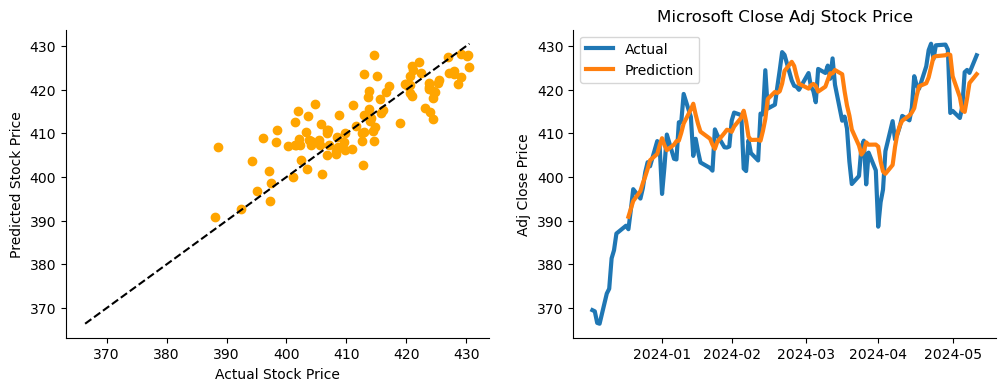

In [13]:
for i, (com, name) in enumerate(zip(companylist, companyname)):
    data = sc.fit_transform(com["Adj Close"].values.reshape(-1, 1))  # Use entire dataset

    # Hyperparameters
    windows = 10
    input_size = 1  
    hidden_size = 50
    output_size = 1  

    # Data preprocessing
    dataset = preprocess(data, windows)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # LSTM model initiation
    LSTM = LSTMModel(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()  
    optimizer = optim.Adam(LSTM.parameters(), lr=0.001)

    # LSTM training
    num_epochs = 100
    for epoch in range(num_epochs):
        for batch_data, batch_target in dataloader:
            optimizer.zero_grad()
            output = LSTM(batch_data)
            loss = criterion(output, batch_target)
            loss.backward()
            optimizer.step()

    LSTM.eval()

    # Prediction and record
    Prediction = pd.DataFrame(com["Adj Close"].values, columns=["Adj Close"])

    # Predicting on the entire dataset
    predicted_prices = []
    for j in range(len(data) - windows):
        last_sequence = torch.FloatTensor(data[j:j + windows].reshape(1, windows, input_size))
        with torch.no_grad():
            predicted_price = LSTM(last_sequence)
        predicted_prices.append(sc.inverse_transform(predicted_price.numpy())[0][0])  # Store predicted price

    # Create a DataFrame for predictions
    Prediction["Prediction"] = np.nan
    Prediction["Prediction"].iloc[windows:] = predicted_prices  # Fill predictions starting from the 'windows' index

    # Calculating the MSE
    #LSTM_MSE.append(np.sum((Prediction["Prediction"].dropna() - Prediction["Adj Close"].dropna()) ** 2) / len(Prediction["Prediction"].dropna()))
    print(f"{name} LSTM MSE: {np.sum((Prediction['Prediction'].dropna() - Prediction['Adj Close'].dropna()) ** 2) / len(Prediction['Prediction'].dropna())}")

    fig, ax = plt.subplots(1,2, figsize=(12,4))

    ax[0].scatter(Prediction["Adj Close"], Prediction["Prediction"], color="orange")
    ax[0].plot(np.linspace(min(Prediction["Adj Close"]), max(Prediction["Adj Close"]), 100), np.linspace(min(Prediction["Adj Close"]), max(Prediction["Adj Close"]), 100), color="black", linestyle="--")
    ax[0].set_xlabel("Actual Stock Price")
    ax[0].set_ylabel("Predicted Stock Price")

    # Plotting the stock price with both prediction and observation
    ax[1].plot(com["Date"], com["Adj Close"], linewidth=3, label="Actual")
    ax[1].plot(com["Date"], Prediction["Prediction"], label="Prediction", linewidth=3)
    ax[1].set_ylabel("Adj Close Price")
    ax[1].set_xticks(pd.date_range(start=com["Date"].min(), end=com["Date"].max(), freq='1ME'))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
    ax[1].legend()
    ax[1].set_title(f"{name} Close Adj Stock Price")